In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
from PIL import Image
import random
from pycocotools.coco import COCO
from scipy.ndimage import zoom
import cv2
from IPython.display import display

In [3]:
# Define paths
dataset_path = "/data/SHARE/datasets/"
TRAIN_IMG_DIR = "/data/SHARE/datasets/train2017"
ANN_FILE = "/data/SHARE/datasets/coco/annotations/instances_train2017.json"

# Load COCO annotations
coco = COCO(ANN_FILE)

# Get image IDs from COCO
img_ids = coco.getImgIds()
print(f"Total images in COCO dataset: {len(img_ids)}")

loading annotations into memory...
Done (t=11.49s)
creating index...
index created!
Total images in COCO dataset: 118287


In [4]:
import os

os.chdir("../")
import matplotlib.pyplot as plt
import torch

from src.crosscoder.crosscoder import CrossCoder

torch.set_grad_enabled(False)
import einops
import numpy as np
from datasets import Dataset
from PIL import Image
from tqdm import tqdm

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26
plt.rc("font", size=SMALL_SIZE, family="Times New Roman")  # controls default text sizes
plt.rc(
    "axes", titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE
)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE, labelsize=SMALL_SIZE)  # f

colors = ["#386EC2", "#B5B5B2", "#990006", "#625D0A", "#B9741F", "#213958"]


In [5]:
dtype = torch.float16
ckpt_path = "expansion_factor4_l120.0_dec_init_norm0.1_4_steps"
hookpoint = "down_blocks.2"

crosscoder = CrossCoder.load_from_disk(
    os.path.join(
        ckpt_path,
        hookpoint,
    ),
    device="cuda",
).to(dtype)

model1_dataset_path = "/data/bcywinski/activations/coco2017/sdxl_4/output/"
model2_dataset_path = "/data/bcywinski/activations/coco2017/sdxl-turbo/output/"
model1_num_timesteps = 4
model2_num_timesteps = 4


In [6]:
from src.scripts.train_crosscoder import PairedDataset

model1_dataset = Dataset.load_from_disk(
    os.path.join(model1_dataset_path, hookpoint), keep_in_memory=False
)
model2_dataset = Dataset.load_from_disk(
    os.path.join(model2_dataset_path, hookpoint), keep_in_memory=False
)
model1_dataset.set_format(
    type="torch", columns=["activations", "timestep", "file_name"], dtype=dtype
)
model2_dataset.set_format(
    type="torch", columns=["activations", "timestep", "file_name"], dtype=dtype
)


paired_dataset = PairedDataset(
    model1_dataset,
    model2_dataset,
    100,
    True,
    model1_num_timesteps,
    model2_num_timesteps,
)
dtype = torch.float16


Loading dataset from disk:   0%|          | 0/858 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/858 [00:00<?, ?it/s]

Estimating norm scaling factors...
Scaling factors: 0.3044708713664281, 0.2534405221679243


In [7]:
avg_activations_per_sample1 = torch.zeros(
    (len(paired_dataset), crosscoder.num_latents), dtype=torch.float16
)
batch_size = 16
dl = torch.utils.data.DataLoader(
    paired_dataset, batch_size=16, shuffle=False, num_workers=4
)
for i, batch in tqdm(enumerate(dl), total=len(dl)):
    acts = batch["model1"]
    acts = acts.to(crosscoder.W_dec.device)
    acts = einops.rearrange(
        acts,
        "batch sample_size d_model -> (batch sample_size) d_model",
    )
    out = einops.einsum(
        acts,
        crosscoder.W_enc[0],
        "batch d_model, d_model d_latent -> batch d_latent",
    )
    out = torch.nn.functional.relu(out + crosscoder.b_enc[0])
    # Reshape to get per-sample activations and compute mean for each sample
    out = out.view(
        batch["model1"].shape[0], -1, crosscoder.num_latents
    )  # [batch, sample_size, num_latents]
    batch_avg_activations = out.mean(dim=1).to(
        dtype=torch.float16
    )  # [batch, num_latents]

    # Store in the correct indices
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, len(paired_dataset))
    avg_activations_per_sample1[start_idx:end_idx] = batch_avg_activations


100%|██████████| 7500/7500 [02:03<00:00, 60.88it/s]


In [8]:
def find_topk_activating_examples(activations_per_sample, latent_idx, k=10):
    topk_indices = torch.argsort(
        activations_per_sample[:, latent_idx], dim=0, descending=True
    )[:k]
    return topk_indices


In [34]:
# Function to load an image from COCO dataset
def load_coco_image(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(TRAIN_IMG_DIR, img_info['file_name'])
    return np.array(Image.open(img_path).convert('RGB')), img_info['file_name']

# Function to create a segmentation mask for all objects in an image
def create_segmentation_mask(img_id):
    # Get image info
    img_info = coco.loadImgs(img_id)[0]
    height, width = img_info['height'], img_info['width']
    
    # Get annotations for this image
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(ann_ids)
    
    # Create a blank mask
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Different colors for different instances
    colors = {}
    cat_names = {}
    
    # Fill the mask with segmentation for each object
    for i, ann in enumerate(anns):
        if 'segmentation' not in ann:
            continue
            
        cat_id = ann['category_id']
        if cat_id not in colors:
            colors[cat_id] = i + 1  # Start from 1, 0 is background
            cat_info = coco.loadCats([cat_id])[0]
            cat_names[cat_id] = cat_info['name']
        
        # Get binary mask for this annotation
        if isinstance(ann['segmentation'], list):  # Polygon format
            obj_mask = np.zeros((height, width), dtype=np.uint8)
            for polygon in ann['segmentation']:
                # Convert flat list to points
                pts = np.array(polygon).reshape(-1, 2).astype(np.int32)
                # Draw filled polygon
                cv2.fillPoly(obj_mask, [pts], 1)
                
            # Add to the main mask with a unique color for this category
            mask[obj_mask > 0] = colors[cat_id]
        elif isinstance(ann['segmentation'], dict):  # RLE format
            try:
                from pycocotools import mask as cocomask
                rle = cocomask.frPyObjects(ann['segmentation'], width, height)
                # rle = ann['segmentation']
                obj_mask = cocomask.decode(rle)
                if len(obj_mask.shape) == 3:
                    obj_mask = (obj_mask.sum(axis=2) > 0).astype(np.uint8)
                    
                # Add to the main mask with a unique color for this category
                mask[obj_mask > 0] = colors[cat_id]
            except Exception as e:
                print(f"Error decoding RLE: {str(e)}")
    
    return mask, colors, cat_names

In [10]:
# Function to create a colored segmentation mask for visualization
def create_colored_segmentation(mask, colors, cat_names):
    """Create a colored segmentation mask with a legend."""
    # Create a colormap for visualization
    # We'll use distinct colors for different categories
    num_categories = max(colors.values()) + 1 if colors else 1  # +1 for background (0), default to 1 if no colors
    cmap = plt.cm.get_cmap('tab20', num_categories)
    
    # Convert mask to RGB
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    
    # Map of category id to actual color index used
    cat_to_color_idx = {}
    
    for cat_id, color_idx in colors.items():
        # Get RGB color from colormap
        rgb = np.array(cmap(color_idx)[:3]) * 255
        
        # Set pixels of this category to this color
        colored_mask[mask == color_idx] = rgb
        
        # Store the mapping
        cat_to_color_idx[cat_id] = color_idx
    
    # Create a legend dictionary with category name and color
    legend = {}
    for cat_id, name in cat_names.items():
        if cat_id in cat_to_color_idx:
            color_idx = cat_to_color_idx[cat_id]
            legend[name] = cmap(color_idx)[:3]
    
    return colored_mask, legend

In [15]:
def analyze_activation_segmentation_overlap(activation_map, seg_mask, colors, cat_names, threshold=0.5):
    """
    Analyze which segmentation classes are highlighted by the activation map.
    
    Args:
        activation_map: Normalized activation map (values between 0 and 1)
        seg_mask: Segmentation mask with class indices
        colors: Dictionary mapping category_id to color_idx
        cat_names: Dictionary mapping category_id to category name
        threshold: Activation threshold (pixels with activation > threshold are considered "activated")
    
    Returns:
        Dictionary with overlap statistics
    """
    # Ensure activation map is normalized to [0,1]
    if activation_map.max() > 1:
        activation_map = activation_map / activation_map.max()
    
    # Create a mask of activated pixels (above threshold)
    activated_pixels = activation_map > threshold
    total_activated_pixels = np.sum(activated_pixels)
    
    # Create a reverse mapping from color index to category ID
    color_to_cat = {color_idx: cat_id for cat_id, color_idx in colors.items()}
    
    # Count total pixels for each class
    unique_colors, class_pixel_counts = np.unique(seg_mask, return_counts=True)
    
    # Count activated pixels for each class
    overlap_counts = {}
    overlap_percentages = {}
    
    # First handle background (color 0)
    background_mask = seg_mask == 0
    background_activated = np.logical_and(background_mask, activated_pixels)
    background_activated_count = np.sum(background_activated)
    
    # Calculate percentages
    if total_activated_pixels > 0:
        background_percentage = (background_activated_count / total_activated_pixels) * 100
    else:
        background_percentage = 0
    
    overlap_counts["Background"] = int(background_activated_count)
    overlap_percentages["Background"] = background_percentage
    
    # Handle all other classes
    for color in unique_colors:
        if color == 0:  # Skip background (already processed)
            continue
            
        # Get class name
        if color in color_to_cat:
            cat_id = color_to_cat[color]
            name = cat_names.get(cat_id, f"Unknown-{cat_id}")
        else:
            name = f"Unknown-{color}"
        
        # Count overlap
        class_mask = seg_mask == color
        class_activated = np.logical_and(class_mask, activated_pixels)
        activated_count = np.sum(class_activated)
        
        # Calculate percentage of activated pixels in this class
        if total_activated_pixels > 0:
            percentage = (activated_count / total_activated_pixels) * 100
        else:
            percentage = 0
            
        overlap_counts[name] = int(activated_count)
        overlap_percentages[name] = percentage
    
    # Print results
    # print(f"Activation-Segmentation Overlap Analysis (threshold = {threshold}):")
    # print(f"Total activated pixels: {total_activated_pixels}")
    # print("-" * 70)
    # print(f"{'Class':<20} | {'Activated Pixels':<15} | {'% of Activation':<15} | {'Class Coverage':<15}")
    # print("-" * 70)
    
    # Sort classes by activated pixel count (descending)
    sorted_classes = sorted(overlap_counts.keys(), key=lambda x: overlap_counts[x], reverse=True)
    
    for class_name in sorted_classes:
        activated_count = overlap_counts[class_name]
        percentage = overlap_percentages[class_name]
        
        # Calculate coverage (percentage of class pixels that are activated)
        if class_name == "Background":
            total_class_pixels = class_pixel_counts[0] if 0 in unique_colors else 0
        else:
            # Find the color index for this class
            color_idx = None
            for c, cat_id in color_to_cat.items():
                if cat_names.get(cat_id, "") == class_name:
                    color_idx = c
                    break
            
            if color_idx is not None and color_idx in unique_colors:
                idx = np.where(unique_colors == color_idx)[0][0]
                total_class_pixels = class_pixel_counts[idx]
            else:
                total_class_pixels = 0
        
        coverage = (activated_count / total_class_pixels) * 100 if total_class_pixels > 0 else 0
        
        # print(f"{class_name:<20} | {activated_count:<15} | {percentage:.2f}%{' ':>9} | {coverage:.2f}%{' ':>9}")
    
    # print("-" * 70)
    
    return {
        "total_activated_pixels": total_activated_pixels,
        "overlap_counts": overlap_counts,
        "overlap_percentages": overlap_percentages
    }

In [20]:
norms = crosscoder.W_dec.norm(dim=-1).cpu()
norms.shape

relative_norms = norms[:, 1] / norms.sum(dim=-1)
relative_norms.shape

only_base_features = relative_norms < 0.25
only_turbo_features = relative_norms > 0.75
shared_features = (relative_norms >= 0.25) & (relative_norms <= 0.75)


In [22]:
@torch.no_grad()
def analyze_feature_class_associations(features, activation_threshold=0.5, k=10):
    # Initialize return dictionaries
    class_to_latents = {} # {class_name: {'latent_idxs': [], 'overlap_percentages': []}}
    latent_to_overlaps = {} # {latent_idx: {class_name: avg_percentage}}
    
    for i,latent_idx in enumerate(features):
        print(i)
        topk_indices1 = find_topk_activating_examples(
            avg_activations_per_sample1, latent_idx, k)
        topk_samples1 = paired_dataset[topk_indices1.tolist()]
        sae_latents1 = []
        activations1 = topk_samples1["model1"]
        timesteps1 = topk_samples1["model1_timestep"]
        file_names_topk1 = topk_samples1["file_name"]
        activations1 = einops.rearrange(
            activations1,
            "batch sample_size d_model -> (batch sample_size) d_model",
        )
        activations1 = activations1.to(crosscoder.W_dec.device)
        out = einops.einsum(
            activations1,
            crosscoder.W_enc[0],
            "batch d_model, d_model d_latent -> batch d_latent",
        )
        out = torch.nn.functional.relu(out + crosscoder.b_enc[0])
        sae_latents1 = out.view(k, -1, crosscoder.num_latents)

        # Track class overlap percentages across all images for this latent
        class_overlap_sums = {}
        class_overlap_counts = {}

        for i in range(len(topk_indices1)):
            img1 = Image.open(os.path.join(dataset_path, file_names_topk1[i]))
            image_id = int(file_names_topk1[i].split('/')[-1].split('.')[0].lstrip('0'))
            seg_mask, colors, cat_names = create_segmentation_mask(image_id)
            seg_mask = Image.fromarray(seg_mask.astype(np.uint8)).resize((512, 512))
            seg_mask = np.array(seg_mask)

            sae_latent_activations1 = sae_latents1[i].reshape(
                int(torch.sqrt(torch.tensor(sae_latents1.shape[1])).item()),
                int(torch.sqrt(torch.tensor(sae_latents1.shape[1])).item()),
                -1,
            )[:, :, latent_idx]
            activation_map1 = sae_latent_activations1[:, :].detach().cpu().numpy()
            activation_map1 = (activation_map1 - activation_map1.min()) / (
                activation_map1.max() - activation_map1.min() + 1e-8
            )

            patch_size1 = 512 // activation_map1.shape[0]
            activation_map1 = np.kron(activation_map1, np.ones((patch_size1, patch_size1)))

            overlap_stats = analyze_activation_segmentation_overlap(
                activation_map1, seg_mask, colors, cat_names, threshold=activation_threshold
            )

            # Update running sums for each class
            for class_name, percentage in overlap_stats['overlap_percentages'].items():
                if not class_name.startswith('Unknown'):
                    if class_name not in class_overlap_sums:
                        class_overlap_sums[class_name] = 0
                        class_overlap_counts[class_name] = 0
                    class_overlap_sums[class_name] += percentage
                    class_overlap_counts[class_name] += 1

        # Calculate average overlap percentages for this latent
        latent_to_overlaps[latent_idx.item()] = {}
        for class_name in class_overlap_sums:
            avg_percentage = class_overlap_sums[class_name] / class_overlap_counts[class_name]
            latent_to_overlaps[latent_idx.item()][class_name] = avg_percentage
            
            # Update class_to_latents
            if class_name not in class_to_latents:
                class_to_latents[class_name] = {
                    'latent_idxs': [],
                    'overlap_percentages': []
                }
            class_to_latents[class_name]['latent_idxs'].append(latent_idx.item())
            class_to_latents[class_name]['overlap_percentages'].append(avg_percentage)

    return class_to_latents, latent_to_overlaps


In [43]:
# First analyze and save results
threshold = 0.01
class_to_latents_base, latent_to_overlaps_base = analyze_feature_class_associations(torch.where(only_base_features)[0], activation_threshold=threshold)
class_to_latents_shared, latent_to_overlaps_shared = analyze_feature_class_associations(torch.where(shared_features)[0], activation_threshold=threshold)
class_to_latents_turbo, latent_to_overlaps_turbo = analyze_feature_class_associations(torch.where(only_turbo_features)[0], activation_threshold=threshold)

# Save all dictionarie

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/tmp/ipykernel_1271666/1575282729.py:46: RuntimeWarning: invalid value encountered in divide
  activation_map1 = (activation_map1 - activation_map1.min()) / (


15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
2

In [44]:
import pickle

os.makedirs('latents_segmentation_overlaps', exist_ok=True)
with open(f'latents_segmentation_overlaps/class_to_latents_base_k_10_th_{threshold}.pkl', 'wb') as f:
    pickle.dump(class_to_latents_base, f)
with open(f'latents_segmentation_overlaps/latent_to_overlaps_base_k_10_th_{threshold}.pkl', 'wb') as f:
    pickle.dump(latent_to_overlaps_base, f)
with open(f'latents_segmentation_overlaps/class_to_latents_shared_k_10_th_{threshold}.pkl', 'wb') as f:
    pickle.dump(class_to_latents_shared, f)
with open(f'latents_segmentation_overlaps/latent_to_overlaps_shared_k_10_th_{threshold}.pkl', 'wb') as f:
    pickle.dump(latent_to_overlaps_shared, f)
with open(f'latents_segmentation_overlaps/class_to_latents_turbo_k_10_th_{threshold}.pkl', 'wb') as f:
    pickle.dump(class_to_latents_turbo, f)
with open(f'latents_segmentation_overlaps/latent_to_overlaps_turbo_k_10_th_{threshold}.pkl', 'wb') as f:
    pickle.dump(latent_to_overlaps_turbo, f)

In [58]:
# Load the saved dictionaries
with open('latents_segmentation_overlaps/class_to_latents_base.pkl', 'rb') as f:
    class_to_latents_base = pickle.load(f)
with open('latents_segmentation_overlaps/latent_to_overlaps_base.pkl', 'rb') as f:
    latent_to_overlaps_base = pickle.load(f)
with open('latents_segmentation_overlaps/class_to_latents_shared.pkl', 'rb') as f:
    class_to_latents_shared = pickle.load(f)
with open('latents_segmentation_overlaps/latent_to_overlaps_shared.pkl', 'rb') as f:
    latent_to_overlaps_shared = pickle.load(f)
with open('latents_segmentation_overlaps/class_to_latents_turbo.pkl', 'rb') as f:
    class_to_latents_turbo = pickle.load(f)
with open('latents_segmentation_overlaps/latent_to_overlaps_turbo.pkl', 'rb') as f:
    latent_to_overlaps_turbo = pickle.load(f)

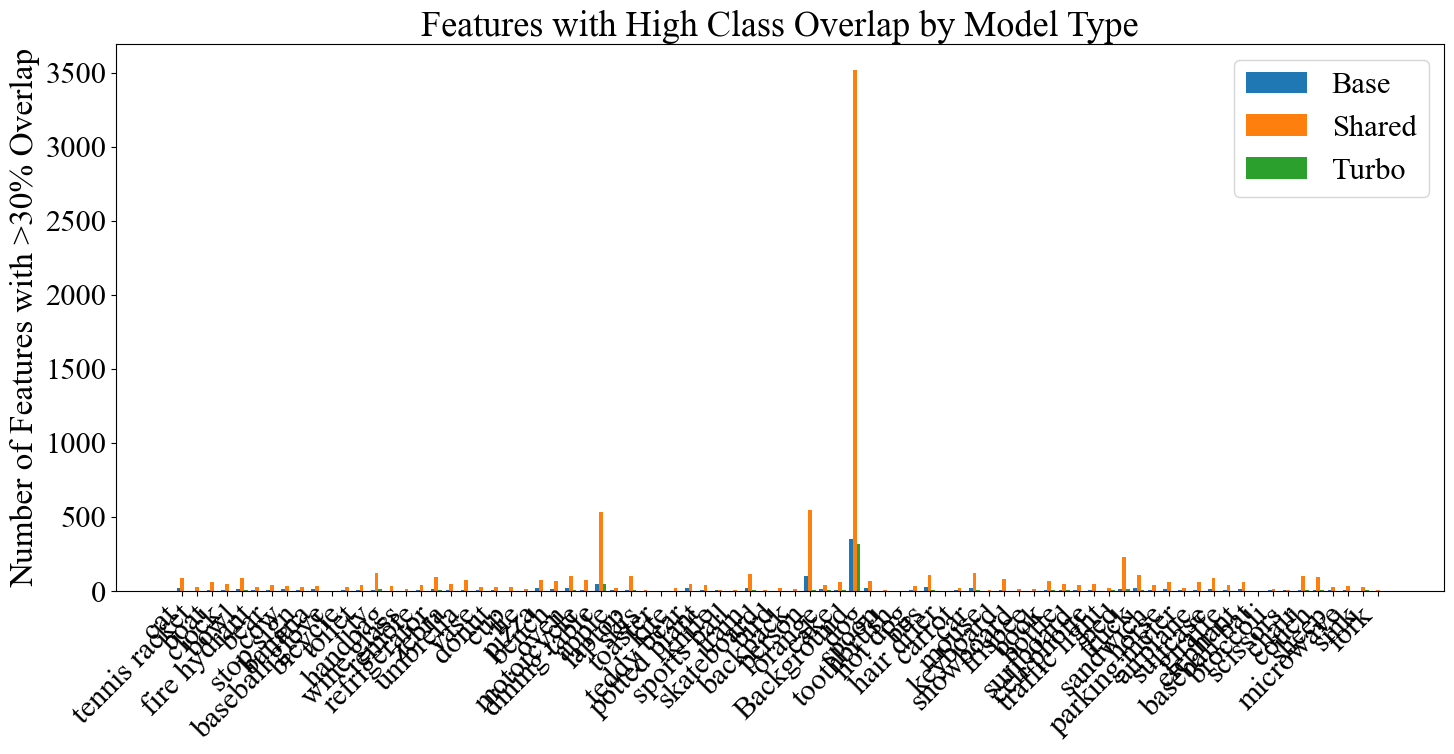

In [55]:
# Count features with >30% overlap for each class and group
class_counts = {}

for class_name in set().union(
    class_to_latents_base.keys(), 
    class_to_latents_shared.keys(),
    class_to_latents_turbo.keys()
):
    base_count = sum(1 for p in class_to_latents_base.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    shared_count = sum(1 for p in class_to_latents_shared.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    turbo_count = sum(1 for p in class_to_latents_turbo.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    
    class_counts[class_name] = {
        'Base': base_count,
        'Shared': shared_count, 
        'Turbo': turbo_count
    }

# Create bar plot
import matplotlib.pyplot as plt
import numpy as np

classes = list(class_counts.keys())
base_counts = [class_counts[c]['Base'] for c in classes]
shared_counts = [class_counts[c]['Shared'] for c in classes]
turbo_counts = [class_counts[c]['Turbo'] for c in classes]

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width, base_counts, width, label='Base')
ax.bar(x, shared_counts, width, label='Shared')
ax.bar(x + width, turbo_counts, width, label='Turbo')

ax.set_ylabel('Number of Features with >30% Overlap')
ax.set_title('Features with High Class Overlap by Model Type')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

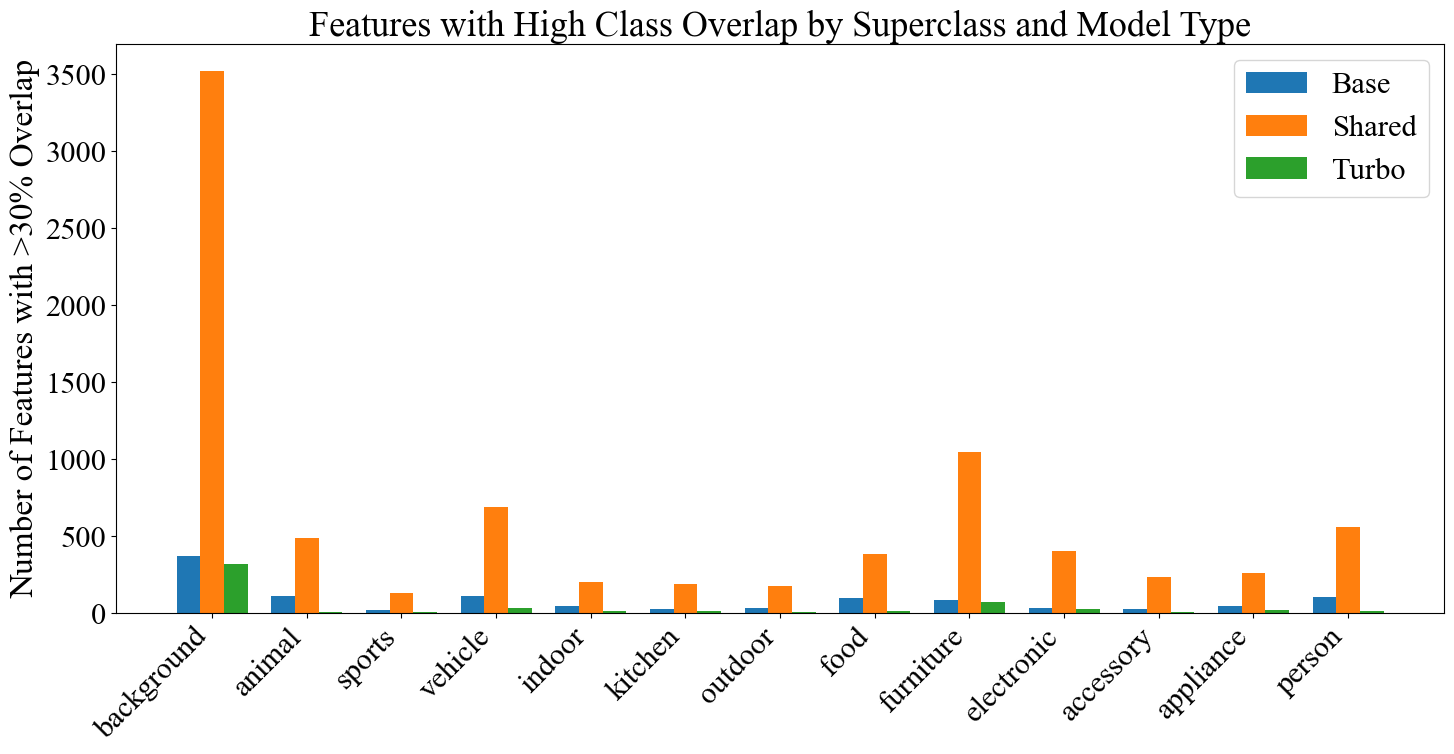

In [46]:
# Define COCO superclass groupings
coco_groups = {
    'background': ['Background'],  # Separate group for background
    'person': ['person'],
    'vehicle': ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat'],
    'outdoor': ['traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench'],
    'animal': ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'],
    'accessory': ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase'],
    'sports': ['frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket'],
    'kitchen': ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl'],
    'food': ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake'],
    'furniture': ['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet'],
    'electronic': ['tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone'],
    'appliance': ['microwave', 'oven', 'toaster', 'sink', 'refrigerator'],
    'indoor': ['book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
}

# Create reverse mapping from class to superclass
class_to_group = {}
for group, classes in coco_groups.items():
    for c in classes:
        class_to_group[c] = group

# Count features with >30% overlap for each class and group
group_counts = {}

for class_name in set().union(
    class_to_latents_base.keys(), 
    class_to_latents_shared.keys(),
    class_to_latents_turbo.keys()
):
    base_count = sum(1 for p in class_to_latents_base.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    shared_count = sum(1 for p in class_to_latents_shared.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    turbo_count = sum(1 for p in class_to_latents_turbo.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    
    # Special handling for background class
    if class_name == 'background':
        group = 'background'
    else:
        group = class_to_group.get(class_name, 'other')
        
    if group not in group_counts:
        group_counts[group] = {'Base': 0, 'Shared': 0, 'Turbo': 0}
    
    group_counts[group]['Base'] += base_count
    group_counts[group]['Shared'] += shared_count
    group_counts[group]['Turbo'] += turbo_count

# Create bar plot
import matplotlib.pyplot as plt
import numpy as np

# Ensure background is first in the plot
groups = ['background'] + [g for g in group_counts.keys() if g != 'background']
base_counts = [group_counts[g]['Base'] for g in groups]
shared_counts = [group_counts[g]['Shared'] for g in groups]
turbo_counts = [group_counts[g]['Turbo'] for g in groups]

x = np.arange(len(groups))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width, base_counts, width, label='Base')
ax.bar(x, shared_counts, width, label='Shared')
ax.bar(x + width, turbo_counts, width, label='Turbo')

ax.set_ylabel('Number of Features with >30% Overlap')
ax.set_title('Features with High Class Overlap by Superclass and Model Type')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

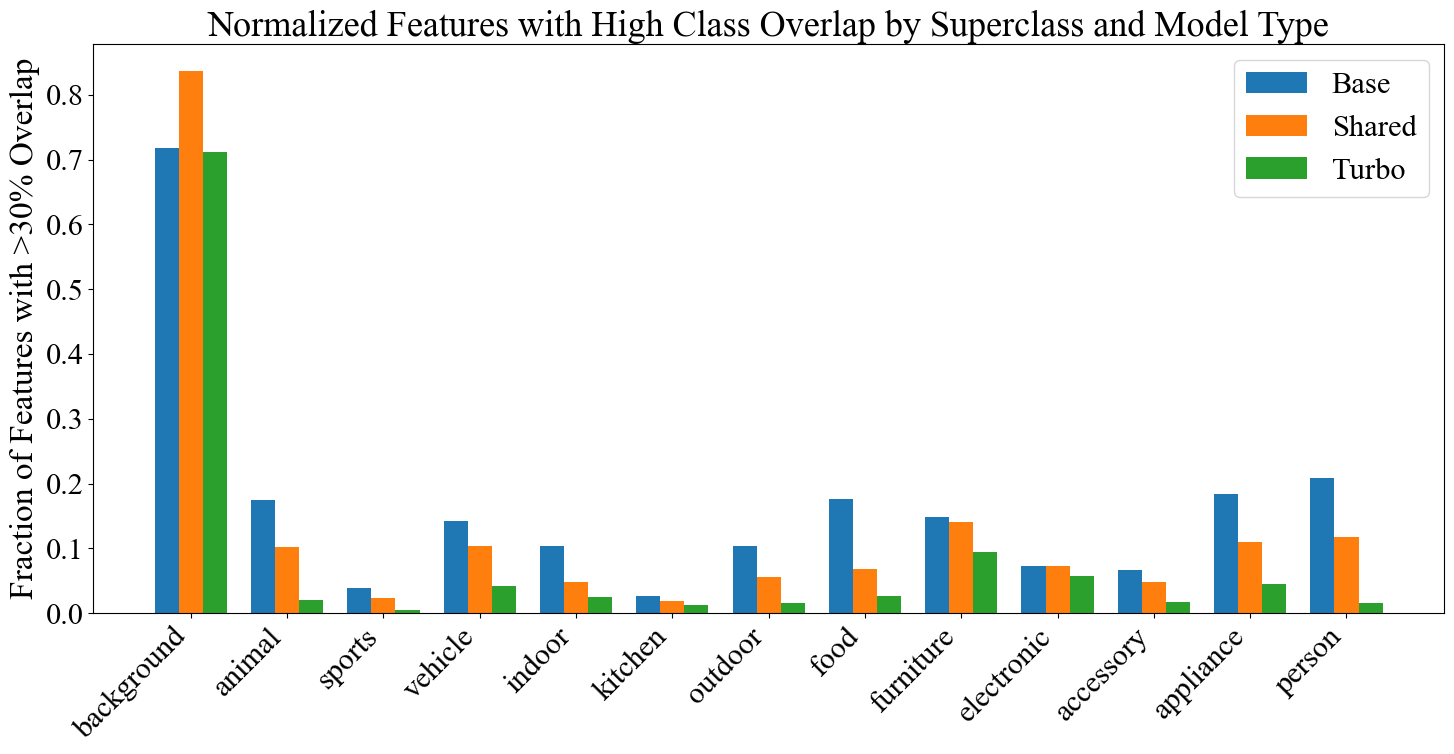

In [59]:
# Define COCO superclass groupings
coco_groups = {
    'background': ['Background'],  # Separate group for background
    'person': ['person'],
    'vehicle': ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat'],
    'outdoor': ['traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench'],
    'animal': ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'],
    'accessory': ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase'],
    'sports': ['frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket'],
    'kitchen': ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl'],
    'food': ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake'],
    'furniture': ['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet'],
    'electronic': ['tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone'],
    'appliance': ['microwave', 'oven', 'toaster', 'sink', 'refrigerator'],
    'indoor': ['book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
}

# Create reverse mapping from class to superclass
class_to_group = {}
for group, classes in coco_groups.items():
    for c in classes:
        class_to_group[c] = group

# Count features with >30% overlap for each class and group
group_counts = {}
group_total_features = {}

for class_name in set().union(
    class_to_latents_base.keys(), 
    class_to_latents_shared.keys(),
    class_to_latents_turbo.keys()
):
    base_count = sum(1 for p in class_to_latents_base.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    shared_count = sum(1 for p in class_to_latents_shared.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    turbo_count = sum(1 for p in class_to_latents_turbo.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 30)
    
    base_total = len(class_to_latents_base.get(class_name, {'overlap_percentages':[]})['overlap_percentages'])
    shared_total = len(class_to_latents_shared.get(class_name, {'overlap_percentages':[]})['overlap_percentages'])
    turbo_total = len(class_to_latents_turbo.get(class_name, {'overlap_percentages':[]})['overlap_percentages'])
    
    # Special handling for background class
    if class_name == 'background':
        group = 'background'
    else:
        group = class_to_group.get(class_name, 'other')
        
    if group not in group_counts:
        group_counts[group] = {'Base': 0, 'Shared': 0, 'Turbo': 0}
        group_total_features[group] = {'Base': 0, 'Shared': 0, 'Turbo': 0}
    
    group_counts[group]['Base'] += base_count
    group_counts[group]['Shared'] += shared_count
    group_counts[group]['Turbo'] += turbo_count
    
    group_total_features[group]['Base'] += base_total
    group_total_features[group]['Shared'] += shared_total
    group_total_features[group]['Turbo'] += turbo_total

# Create bar plot
import matplotlib.pyplot as plt
import numpy as np

# Ensure background is first in the plot
groups = ['background'] + [g for g in group_counts.keys() if g != 'background']

# Calculate normalized counts
base_counts = [group_counts[g]['Base'] / group_total_features[g]['Base'] if group_total_features[g]['Base'] > 0 else 0 for g in groups]
shared_counts = [group_counts[g]['Shared'] / group_total_features[g]['Shared'] if group_total_features[g]['Shared'] > 0 else 0 for g in groups]
turbo_counts = [group_counts[g]['Turbo'] / group_total_features[g]['Turbo'] if group_total_features[g]['Turbo'] > 0 else 0 for g in groups]

x = np.arange(len(groups))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width, base_counts, width, label='Base')
ax.bar(x, shared_counts, width, label='Shared')
ax.bar(x + width, turbo_counts, width, label='Turbo')

ax.set_ylabel('Fraction of Features with >30% Overlap')
ax.set_title('Normalized Features with High Class Overlap by Superclass and Model Type')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

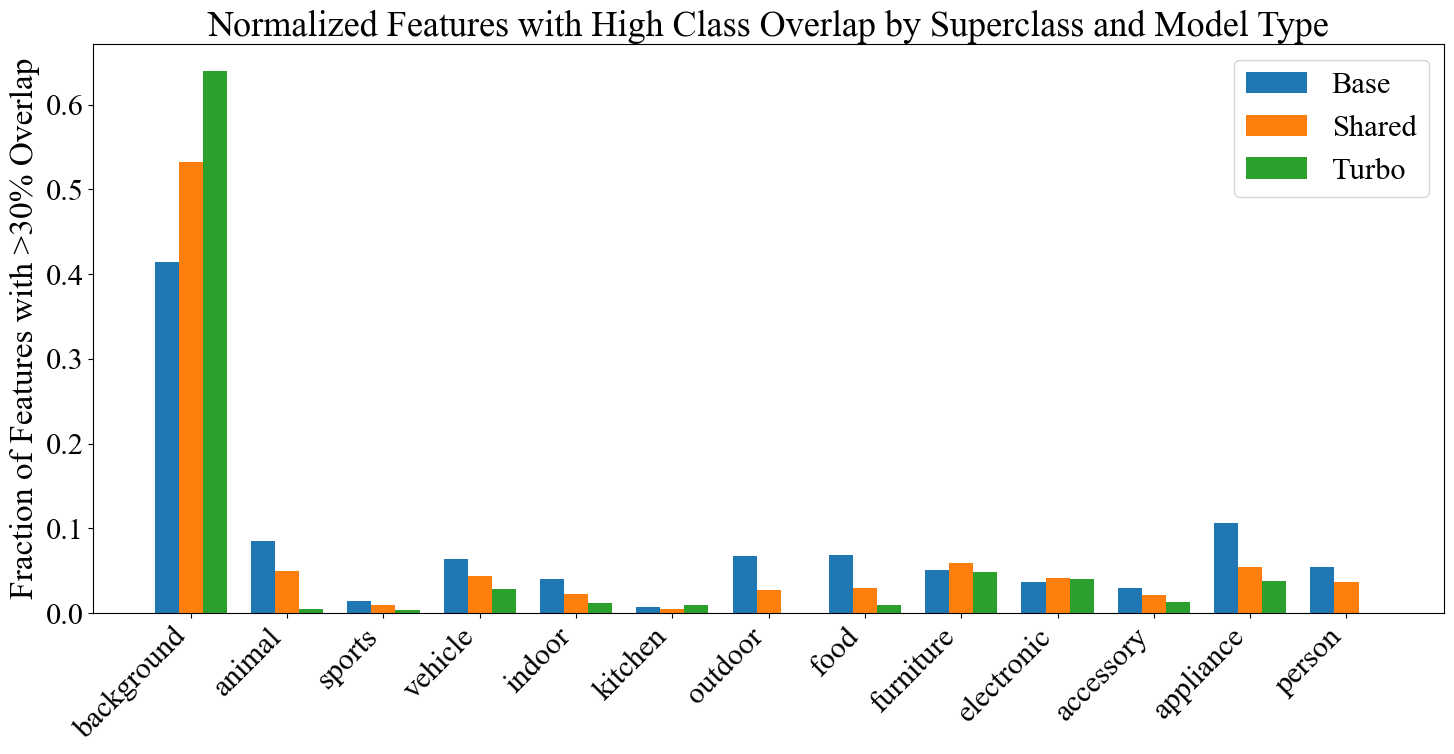

In [53]:
# Define COCO superclass groupings
coco_groups = {
    'background': ['Background'],  # Separate group for background
    'person': ['person'],
    'vehicle': ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat'],
    'outdoor': ['traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench'],
    'animal': ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'],
    'accessory': ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase'],
    'sports': ['frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket'],
    'kitchen': ['bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl'],
    'food': ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake'],
    'furniture': ['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet'],
    'electronic': ['tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone'],
    'appliance': ['microwave', 'oven', 'toaster', 'sink', 'refrigerator'],
    'indoor': ['book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
}

# Create reverse mapping from class to superclass
class_to_group = {}
for group, classes in coco_groups.items():
    for c in classes:
        class_to_group[c] = group

# Count features with >30% overlap for each class and group
group_counts = {}
group_total_features = {}

for class_name in set().union(
    class_to_latents_base.keys(), 
    class_to_latents_shared.keys(),
    class_to_latents_turbo.keys()
):
    base_count = sum(1 for p in class_to_latents_base.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 80)
    shared_count = sum(1 for p in class_to_latents_shared.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 80)
    turbo_count = sum(1 for p in class_to_latents_turbo.get(class_name, {'overlap_percentages':[]})['overlap_percentages'] if p > 80)
    
    base_total = len(class_to_latents_base.get(class_name, {'overlap_percentages':[]})['overlap_percentages'])
    shared_total = len(class_to_latents_shared.get(class_name, {'overlap_percentages':[]})['overlap_percentages'])
    turbo_total = len(class_to_latents_turbo.get(class_name, {'overlap_percentages':[]})['overlap_percentages'])
    
    # Special handling for background class
    if class_name == 'background':
        group = 'background'
    else:
        group = class_to_group.get(class_name, 'other')
        
    if group not in group_counts:
        group_counts[group] = {'Base': 0, 'Shared': 0, 'Turbo': 0}
        group_total_features[group] = {'Base': 0, 'Shared': 0, 'Turbo': 0}
    
    group_counts[group]['Base'] += base_count
    group_counts[group]['Shared'] += shared_count
    group_counts[group]['Turbo'] += turbo_count
    
    group_total_features[group]['Base'] += base_total
    group_total_features[group]['Shared'] += shared_total
    group_total_features[group]['Turbo'] += turbo_total

# Create bar plot
import matplotlib.pyplot as plt
import numpy as np

# Ensure background is first in the plot
groups = ['background'] + [g for g in group_counts.keys() if g != 'background']

# Calculate normalized counts
base_counts = [group_counts[g]['Base'] / group_total_features[g]['Base'] if group_total_features[g]['Base'] > 0 else 0 for g in groups]
shared_counts = [group_counts[g]['Shared'] / group_total_features[g]['Shared'] if group_total_features[g]['Shared'] > 0 else 0 for g in groups]
turbo_counts = [group_counts[g]['Turbo'] / group_total_features[g]['Turbo'] if group_total_features[g]['Turbo'] > 0 else 0 for g in groups]

x = np.arange(len(groups))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width, base_counts, width, label='Base')
ax.bar(x, shared_counts, width, label='Shared')
ax.bar(x + width, turbo_counts, width, label='Turbo')

ax.set_ylabel('Fraction of Features with >30% Overlap')
ax.set_title('Normalized Features with High Class Overlap by Superclass and Model Type')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [57]:
latent_to_overlaps_base[13]

{'Background': np.float64(39.70229363732427),
 'parking meter': np.float64(41.35454963235294),
 'cup': np.float64(0.0),
 'boat': np.float64(0.0),
 'stop sign': np.float64(75.34623579545455),
 'cell phone': np.float64(0.5088348979693552),
 'person': np.float64(54.97580327454697),
 'tie': np.float64(0.23600260416666666),
 'umbrella': np.float64(0.361328125),
 'traffic light': np.float64(0.17578125),
 'handbag': np.float64(2.6708984375),
 'truck': np.float64(1.171875),
 'chair': np.float64(0.13316761363636362),
 'backpack': np.float64(0.0),
 'dining table': np.float64(0.0),
 'snowboard': np.float64(13.548900462962962),
 'vase': np.float64(15.250651041666666),
 'bottle': np.float64(35.67708333333333),
 'skis': np.float64(11.709449404761903)}